Inscopix data analysis

by Edgar Bermudez - edgar.bermudez@gmail.com

November 2020

# Tasks (instructions)
Determine if there is a relationship between the external events in triggers.csv and the neural data in the ca_data csv files. If there is a relationship, characterize it. Consider the 4 ca_data
csv files as independent experiments and evaluate any relationships between external events and neural data across this sample.


Deliverables

1. Provide a report of your findings. Share what you found, how you found it, and how you interpret it. Share anything else that caught your eye!
2. Provide your analysis code

# My approach
After initial visualization of the calcium traces, my first goal will be to align the calcium signal of each neuron to the events onset (triggers). I will then plot the mean activity across events for all neurons in each session. Once that is done, the next step will be to find out which neurons 'pay attention' to the events. Finally, to characterize the temporal structure of the event-evoked responses, I will define latency of a neuron as the number of time bins it takes to reach half-peak amplitude.

*summary*

For each session:
- align traces to events
- display the peri-event time histogram (mean neuronal activity across events)
- Determine neuronal participation (estimation whether neurons pay attention)
- calculate latecy for each participating neuron




# Code

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 8]

## Auxiliary functions

In [ ]:
def subtract_baseline(trace, baseline):
  '''  
  Returns the trace after subtracting the mean during the baseline period
  '''
  # calculate the mean of the neuron activity during the baseline period 
  m_base = np.mean(trace[baseline])
  # subtract the baseline mean to the trace
  return(trace - m_base)


def calculate_participating_nns(peth, baseline, num_bins):
  '''
  Returns a list of neurons indeces that pay attention (or participate in the 
  processing of) to events. To calculate whether neurons pay attention to the 
  events or not we find out whether the activity of each neuron goes above two
  standard deviations from baseline level within a time period (num_bins) after 
  the trigger onset.
  '''

  # participating neurons
  part_nns = []

  for n in range(num_neurons):
    trace = peth[n][:]

    # substract the baseline mean for each trace (so it has zero mean)
    r_baseline_trace = subtract_baseline(trace, baseline)
    # calculate the standard deviation during the baseline (threshold)
    std_baseline = np.std(r_baseline_trace)
    #print(std_baseline*2)
    #print(r_baseline_trace[win_bef:win_bef+num_bins])
    #print(r_baseline_trace[win_bef:win_bef+num_bins] > 2*(std_baseline))

    # if the neuron activity goes above this threshold within a period
    if(np.any(r_baseline_trace[win_bef:win_bef+num_bins] > 2*(std_baseline))):
      # add the neuron to the participation group
      part_nns.append(n)
  
  return part_nns

def get_latency(trace, window):
  '''
  Returns the neuronal latency defined as the time (in bins) it takes for the 
  neuron activity (trace) to reach half-peak (max/2) within a time window (window).
  '''
  # calculate the peak 
  m = np.max(trace[window])
  # index of the half peak
  indx = np.where(trace[window] >= m/2)
   
  if(indx):
    return indx[0][0]
  else:
    return indx[0]


## Definitions

These definitions will be used to characterize the relationship between events and neuronal activity.

In [ ]:

# time windows before and after the event 
win_bef = 10
win_aft = 60

# Note: Usually, the sampling frequency of inscopix recordings  (e.g. [1]),
# goes from 10-20 Hz.  So the window of at least 3 seconds after event onset 
# might be enough to see the dynamics of short sensory stimulus evoked 
# responses. However, more info about the nature of events (duration, 
# habituation, etc) might be necessary to make a more informed decision.

# define baseline (as the time period before the event was triggered)
baseline = range(win_bef)

# define the event-evoked period as 15 time bins after event onset
ev_period = np.array(range(win_bef,win_bef+15))

# Since the sampling frequency is not especified, we will display time in time 
# bins. 
ts = list(range(-win_bef,win_aft))

## Loading data

In [ ]:
# mount my google drive
from google.colab import drive
drive.mount('/content/drive')
!pwd
src_dir =  '/content/drive/My Drive/Colab Notebooks/calcium_inscopix/'

# load datasets for all four sessions
df_data_s1 = pd.read_csv(src_dir + 'ca_data_1.csv')
df_data_s2 = pd.read_csv(src_dir + 'ca_data_2.csv')
df_data_s3 = pd.read_csv(src_dir + 'ca_data_3.csv')
df_data_s4 = pd.read_csv(src_dir + 'ca_data_4.csv')

# load the events for all four sessions
df_events = pd.read_csv(src_dir + 'triggers.csv')

Mounted at /content/drive
/content


## Data structure

A quick peek at how the data is organized (uncomment if necessary)

In [ ]:
# check dataset for the first sessions
# print(df_data_s1.head())
# check events
# print(df_events.head())

In [ ]:
df1 = df_data_s1.transpose()
print(df1.head())
print(df1.shape)



               0         1           2   ...        57         58         59
source     cell_0    cell_1      cell_2  ...   cell_57    cell_58    cell_59
0       -0.247502 -0.116854 -0.00469827  ... -0.317311 -0.0525448 -0.0736281
1       -0.270104  0.189307  -0.0498232  ...  -0.20106 -0.0454796  -0.146788
2       -0.262517  0.231495   0.0507928  ... -0.298454 -0.0869621 -0.0827922
3      -0.0545798  0.157627  -0.0125847  ...   -0.2392  -0.104008 -0.0375413

[5 rows x 60 columns]
(25045, 60)


In [ ]:
# extract the values of the dataframe
df1_vals = df1.values
pts,num_neurons = (df1_vals.shape)
# first take the events for the first session
num_events, num_sessions = (df_events.shape)
idx_events = df_events.values


Preliminary visualization

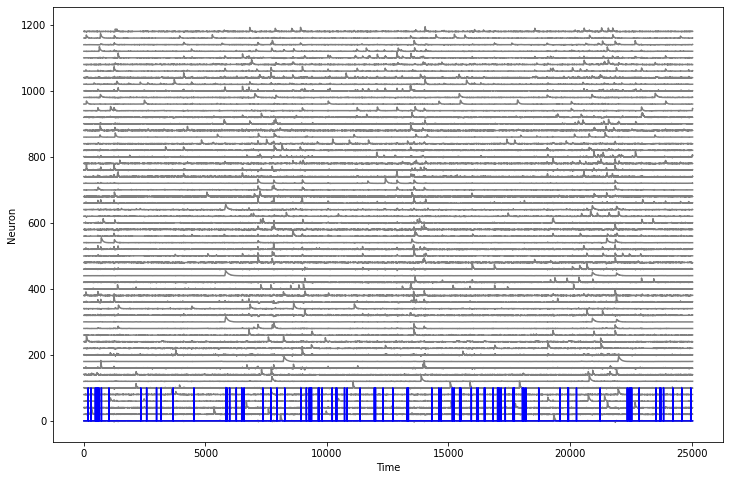

In [ ]:
# plot calcium traces (DF/F_0) for each neuron
for i in range(num_neurons):
  plt.plot(df1_vals[1:,i]+20*i,'gray') # add an offset to be able to see the traces a bit better

# create an array to plot the events on top of the traces
evts = np.zeros((pts,1))
evts[idx_events[:,0]]=100
plt.plot(evts,'blue') # mark the events in blue

plt.xlabel('Time');
plt.ylabel('Neuron');


Just by eye one can tell that the events are not uniformly distributed during the recording so maybe they correspond to consequences of behavioral outcomes rather than something more regular (e.g. sensory stimulation trials). Moreover, we can tell that there are neurons that seem more active than others and that there are times when the activity seems more correlated across neurons than in others.

## First session

In [ ]:
# recording session
session = 0

# array for the event-aligned trials for all events and each neuron
trials = np.zeros([num_neurons, num_events,win_bef+win_aft])

# for every event take a time window around the event
for ev in range(num_events-1):
  # for every neuron
  for n in range(num_neurons):
    trials[n,ev,:] = df1[n][idx_events[ev,session]-win_bef:idx_events[ev,session]+win_aft]


Plot the mean activity across trials for each neuron

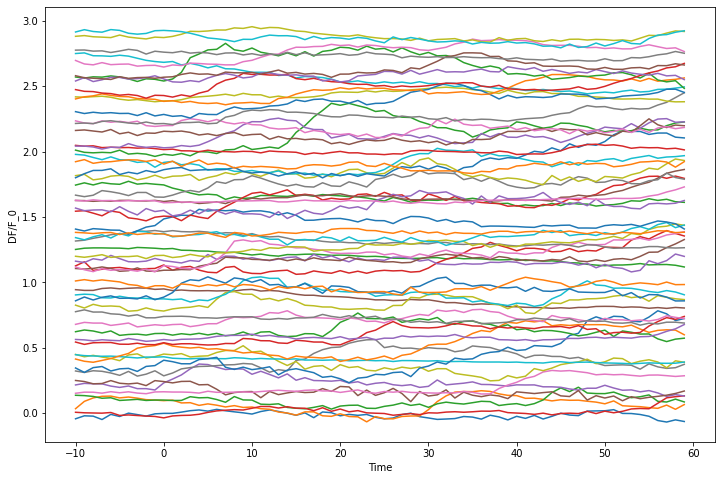

In [ ]:
# peri-event time histogram (peth)
peth = np.mean(trials, axis=1)
for n in range(num_neurons):
  plt.plot( ts, peth[n][:]+n*0.05); # add a small offset to visualize it better
  
plt.xlabel('Time');
plt.ylabel('DF/F_0');

> At first glance it seems that not all neurons respond to the events in the same way. So, to characterize the relationship, I decided to measure the participation of each neuron in the event-evoked response (see calculate_paricipating_nns in the auxiliary functions). To extend this analysis, we could quantify the participation as a function of the amplitude of the response compared to its baseline.

Neuronal participation in the event-evoked response

In [ ]:
# calculate which neurons pay attention to the events
particip_nns = calculate_participating_nns(peth, baseline, 10)
print(particip_nns)

[0, 4, 18, 19, 20, 25, 26, 30, 37, 44, 52, 53, 58]


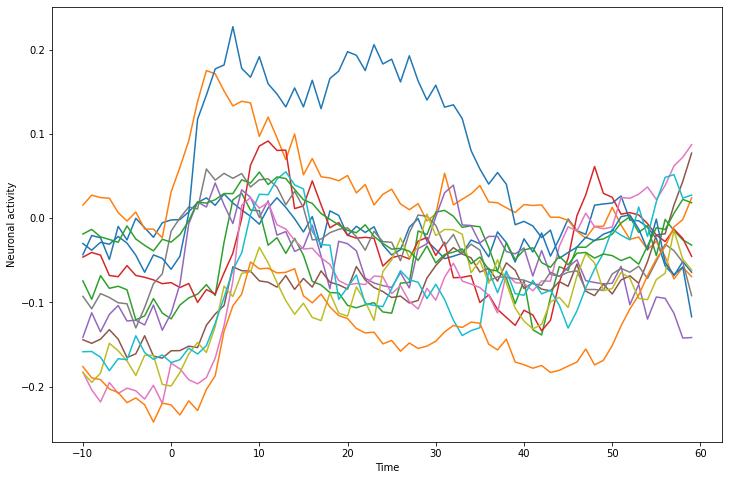

In [ ]:
num_part = len(particip_nns)

# show the peth for the neurons that pay attention to the event
for n in range(num_part):
  plt.plot(ts, peth[particip_nns[n]][:])

plt.xlabel('Time');
plt.ylabel('Neuronal activity');

> It seems that there might be a temporal structure in the population of neurons that responds to the events.

sorted latencies: [0, 2, 2, 2, 3, 3, 6, 6, 6, 7, 7, 8, 9]


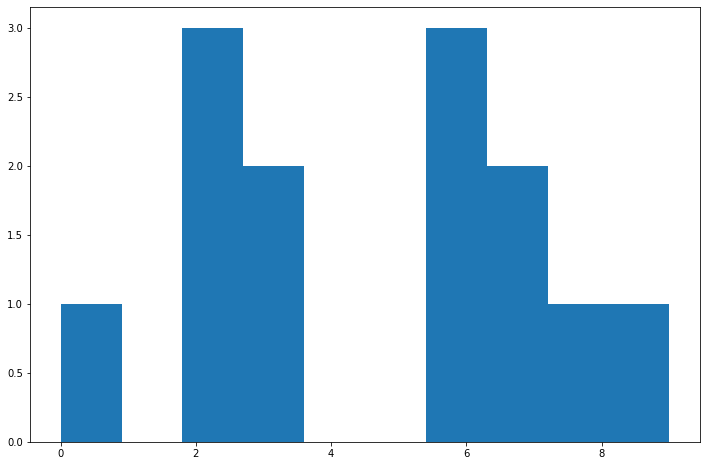

In [ ]:
# calculate the latency of the participating neurons
lat = []
for n in range(num_part):
  trace = subtract_baseline(peth[particip_nns[n]][:], baseline)
  lat.append( get_latency(trace,ev_period))

# TO DO: display participating neurons sorted by their latency
print('sorted latencies: ' + str(sorted(lat)))
sort_indx = np.argsort(lat)
#print(sort_indx)

# one way to visualize the latencies is as a historgam
plt.hist(lat);

There seems to be two groups of neurons. One that responds faster, around 2 time bis after event onset and one that responds later to the event-onset, around 6 time bins after event-onset.

How can we know if the participation criteria is a good one?

> One thing we can do to test how reliable the relationship is between the events and the peri-event time histograms (peth) is to use random events.

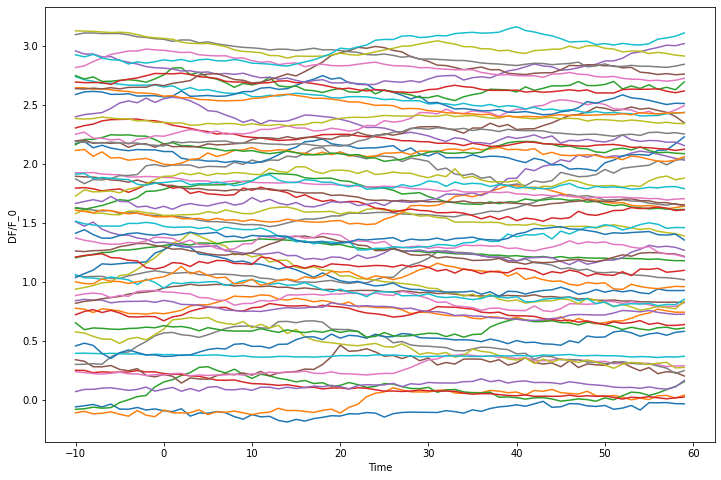

In [ ]:

# generate random event indeces
rand_events = np.sort(np.random.choice(range(pts), num_events))

# for every event take a time window around the event
for ev in range(num_events-1):
  # for every neuron
  for n in range(num_neurons):
    trials[n,ev,:] = df1[n][rand_events[ev]-win_bef:rand_events[ev]+win_aft]

# peri-event time histogram (peth)
rand_peth = np.mean(trials, axis=1)
for n in range(num_neurons):
  plt.plot( ts, rand_peth[n][:]+n*0.05); # add a small offset to visualize it better
  
plt.xlabel('Time');
plt.ylabel('DF/F_0');



[2, 15, 18, 21, 38]


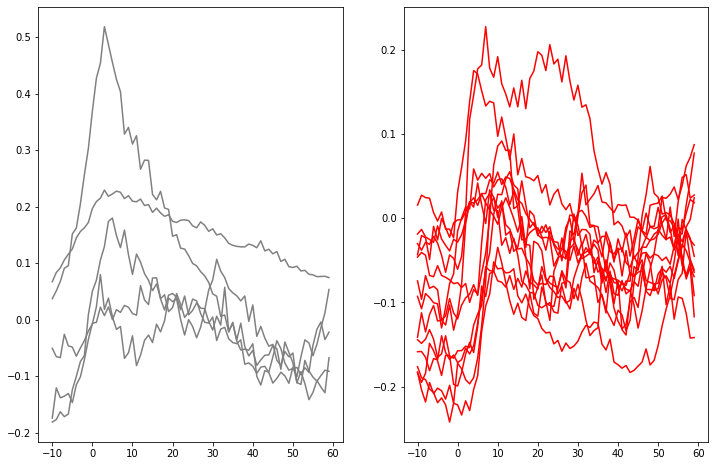

In [ ]:

# calculate which neurons pay attention to the events
rand_particip_nns = calculate_participating_nns(rand_peth, baseline, 10)
print(rand_particip_nns)


num_part_rand = len(rand_particip_nns)

# show the peth for the neurons that pay attention to the event
plt.subplot(1,2,1)
for n in range(num_part_rand):
  plt.plot(ts, rand_peth[rand_particip_nns[n]][:],'gray')

plt.subplot(1,2,2)
for n in range(num_part): 
  plt.plot(ts, peth[particip_nns[n]][:],'red')
  

The responses for randomly selected events (gray) look more like artifacts in comparison with the event-evoked responses of participating neurons (red).  However, it can be that, by chance, we selected random times that on average the neuron seems to be responding to this random events. One way to evaluate this possibility would be to repeat the shuffle process many times and compare them to the participating neurons as we define them.  An interesting point could be to compare the random events with other sessions (e.g. use the events of session 4 to find participating neurons during session 1).

Summary

In [ ]:
print('total neurons: '+str(num_neurons))

print('participating neurons: '+str(num_part))

print(f'{(num_part*100)/num_neurons:.2f}'+'% of the neurons pay attention to the events')

# TO DO: show trial-to-trial variabily and evolution of participation analysis 


total neurons: 60
participating neurons: 13
21.67% of the neurons pay attention to the events


## Second session

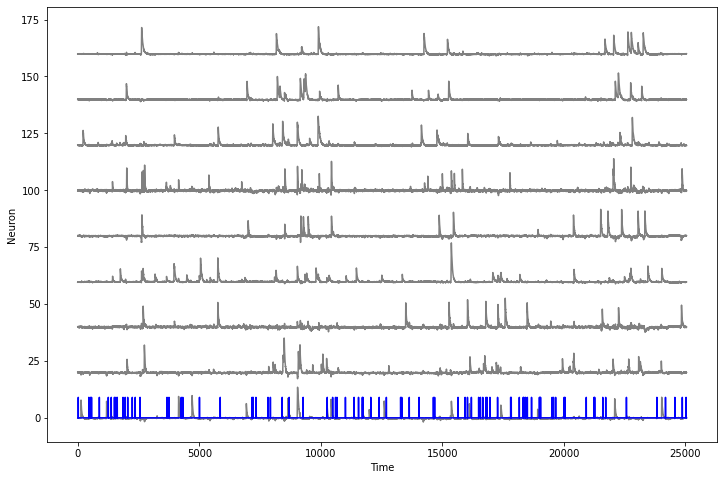

In [ ]:
session = 1
df2 = df_data_s2.transpose()
# extract the values of the dataframe
df2_vals = df2.values
pts,num_neurons = (df2_vals.shape)

# plot calcium traces (DF/F_0) for each neuron
for i in range(num_neurons):
  plt.plot(df2_vals[1:,i]+20*i,'gray')

# create an array to plot the events on top of the traces
evts = np.zeros((pts,1))
evts[idx_events[:,session]]=num_neurons
plt.plot(evts,'blue') # mark the events in blue

plt.xlabel('Time');
plt.ylabel('Neuron');


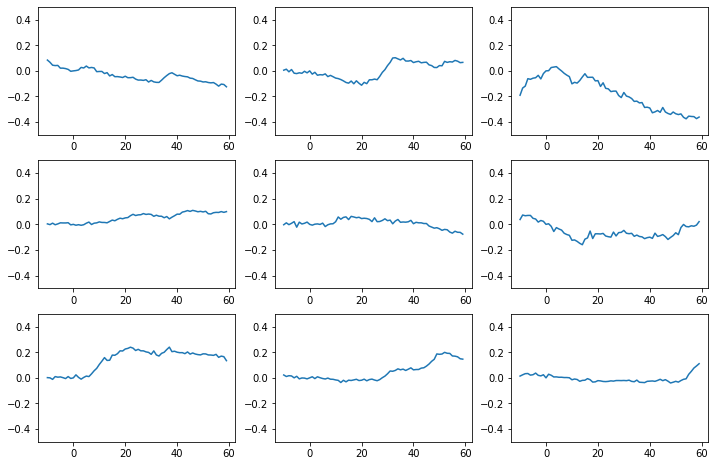

In [ ]:
# array for the timewindows for each event and each neuron
trials = np.zeros([num_neurons, num_events,win_bef+win_aft])

# for every event take a time window around the event
for ev in range(num_events-1):
  # for every neuron
  for n in range(num_neurons):
    trials[n,ev,:] = df2[n][idx_events[ev,session]-win_bef:idx_events[ev,session]+win_aft]


# peri-event time histogram (peth)
peth = np.mean(trials, axis=1)

for n in range(num_neurons):
  ax = plt.subplot(3,3,n+1);
  r_trace =  peth[n][:]
  plt.plot( ts, subtract_baseline(r_trace, win_bef));
  #plt.plot( ts, r_trace);
  plt.ylim(-0.5, 0.5)


>

In [ ]:
# calculate which neurons pay attention to the events
particip_nns = calculate_participating_nns(peth, baseline, 10)
print(particip_nns)


[]


In [ ]:
num_part = len(particip_nns)
print('Number of participating neurons = '+ str(num_part))

Number of participating neurons = 0


> In this session there are only a few neurons recorded. None of them pay attention to the event according to our criteria. It looks like neuron 6 should participate but if you take a closer look, the activity only starts to increase after our allowed window (10 bins after event onset). One might relax the definition and evaluate the changes in neuronal participation during each sessions.

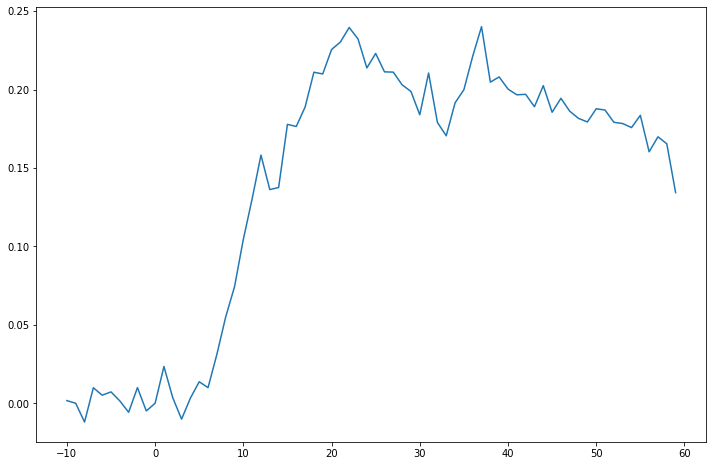

In [ ]:
n= 6
r_trace =  peth[n][:]
plt.plot( ts, subtract_baseline(r_trace, win_bef));

Summary

In [ ]:
print('total neurons: '+str(num_neurons))

print('participating neurons: '+str(particip_nns))

print(f'{(num_part*100)/num_neurons:.2f}'+'% of the neurons pay attention to the events')

# display participating neurons sorted by theit latency

# show trial-to-trial variabily and evolution of participation analysis 


total neurons: 9
participating neurons: []
0.00% of the neurons pay attention to the events


Summary

This session has only nine recorded neurons and it seems that there is no relationship between events and neuronal activity in this case. 

## Third session

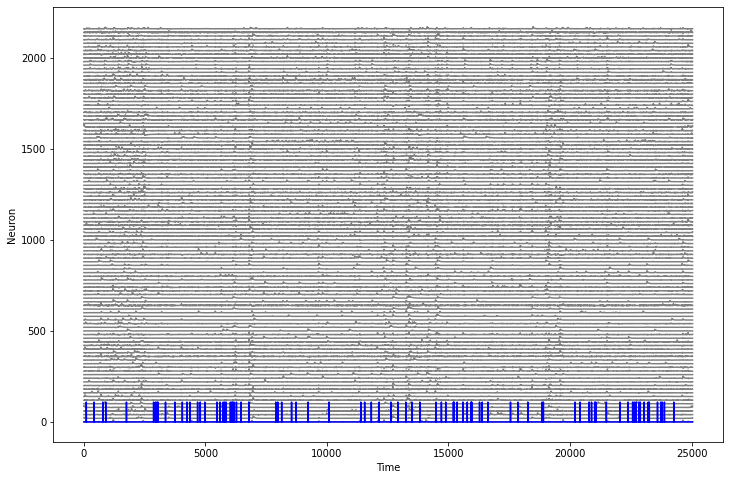

In [ ]:
session = 2
df3 = df_data_s3.transpose()
# extract the values of the dataframe
df3_vals = df3.values
pts,num_neurons = (df3_vals.shape)

# plot calcium traces (DF/F_0) for each neuron
for i in range(num_neurons):
  plt.plot(df3_vals[1:,i]+20*i,'gray')
# create an array to plot the events on top of the traces
evts = np.zeros((pts,1))
evts[idx_events[:,session]]=num_neurons
plt.plot(evts,'blue') # mark the events in blue

plt.xlabel('Time');
plt.ylabel('Neuron');

Event triggered activity




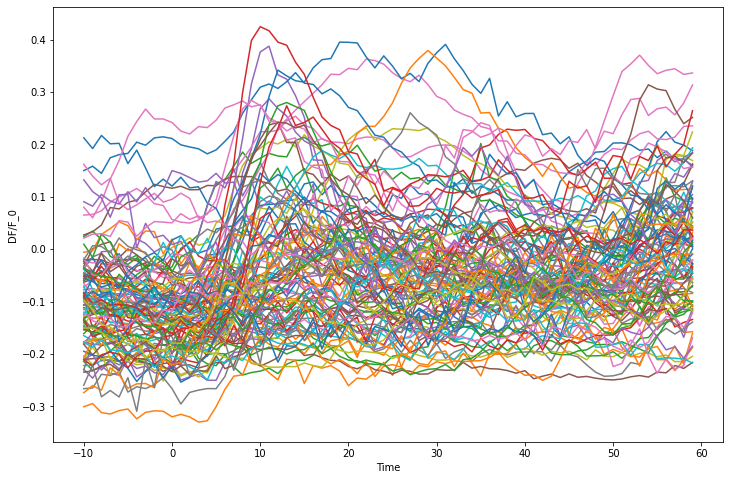

In [ ]:
# array for the timewindows for each event and each neuron
trials = np.zeros([num_neurons, num_events,win_bef+win_aft])

# for every event take a time window around the event
for ev in range(num_events-1):
  # for every neuron
  for n in range(num_neurons):
    trials[n,ev,:] = df3[n][idx_events[ev,session]-win_bef:idx_events[ev,session]+win_aft]

# peri-event time histogram (peth)
peth = np.mean(trials, axis=1)

for n in range(num_neurons):
  plt.plot( ts, peth[n][:]+n*0.00);

plt.xlabel('Time');
plt.ylabel('DF/F_0');


In [ ]:
# calculate which neurons pay attention to the events
particip_nns = calculate_participating_nns(peth, baseline, 10)
print(particip_nns)


[1, 3, 8, 9, 12, 14, 24, 37, 45, 54, 55, 56, 60, 62, 68, 77, 79, 81, 90, 93, 101, 105, 108]


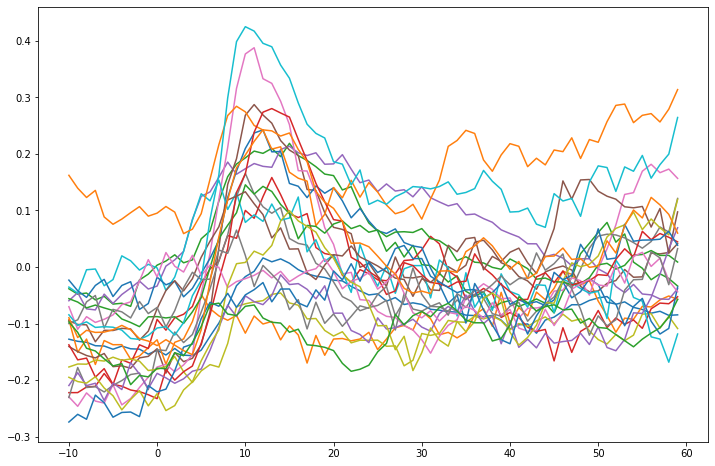

In [ ]:
num_part = len(particip_nns)

# show the peth for the neurons that pay attention to the event
for n in range(num_part):
  plt.plot(ts, peth[particip_nns[n]][:])

sorted latencies: [0, 4, 4, 4, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9]


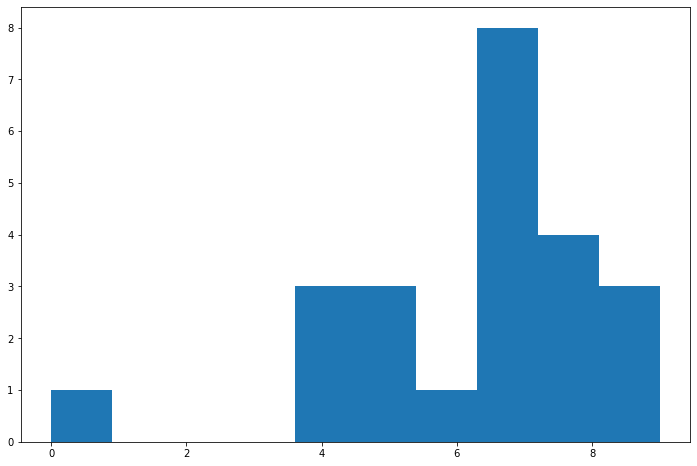

In [ ]:
# calculate the latency of the participating neurons
lat = []
for n in range(num_part):
  trace = subtract_baseline(peth[particip_nns[n]][:], baseline)
  lat.append( get_latency(trace,ev_period))

# TO DO: display participating neurons sorted by their latency
print('sorted latencies: ' + str(sorted(lat)))
sort_indx = np.argsort(lat)
#print(sort_indx)

# one way to visualize the latencies is as a historgam
plt.hist(lat);

Summary

In [ ]:
print('total neurons: '+str(num_neurons))

print('participating neurons: '+str(num_part))

print(f'{(num_part*100)/num_neurons:.2f}'+'% of the neurons pay attention to the events')

# show trial-to-trial variabily and evolution of participation analysis 


total neurons: 109
participating neurons: 23
21.10% of the neurons pay attention to the events


In this session the event-evoked responses seem more clear and have nicer shapes. As well, there is a larger percentage of participating neurons compared to previous sessions. However, during this sessions there are more recorded neurons so it could be that the chances are increased just by increasing the number of neurons sampled.

## Fourth session

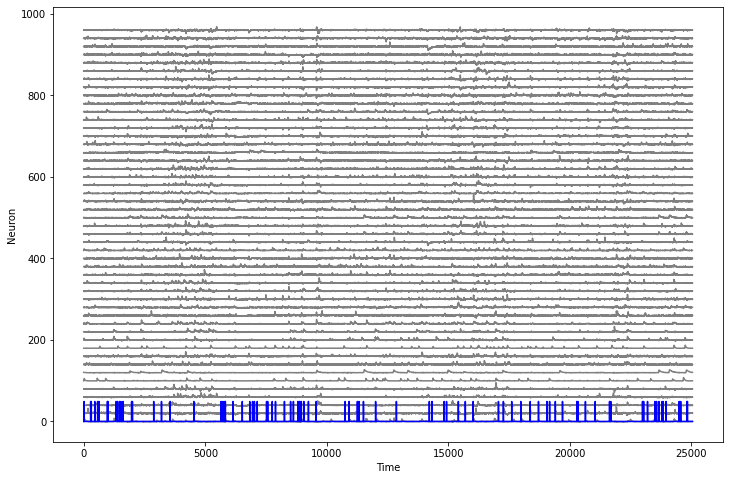

In [ ]:
session = 3
df4 = df_data_s4.transpose()
# extract the values of the dataframe
df4_vals = df4.values
pts,num_neurons = (df4_vals.shape)

# plot calcium traces (DF/F_0) for each neuron
for i in range(num_neurons):
  plt.plot(df4_vals[1:,i]+20*i,'gray')
# create an array to plot the events on top of the traces
evts = np.zeros((pts,1))
evts[idx_events[:,session]]=num_neurons
plt.plot(evts,'blue') # mark the events in blue

plt.xlabel('Time');
plt.ylabel('Neuron');

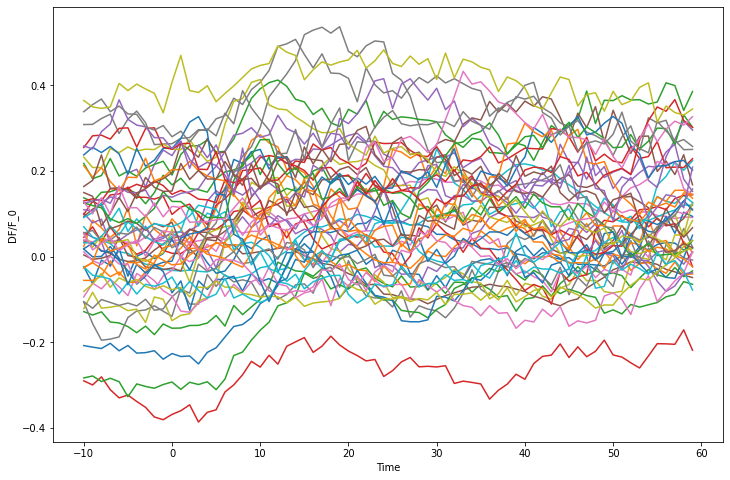

In [ ]:
# array for the timewindows for each event and each neuron
trials = np.zeros([num_neurons, num_events,win_bef+win_aft])

# for every event take a time window around the event
for ev in range(num_events-1):
  # for every neuron
  for n in range(num_neurons):
    trials[n,ev,:] = df4[n][idx_events[ev,session]-win_bef:idx_events[ev,session]+win_aft]

# peri-event time histogram (peth)
peth = np.mean(trials, axis=1)

for n in range(num_neurons):
  plt.plot( ts, peth[n][:]+n*0.005);

plt.xlabel('Time');
plt.ylabel('DF/F_0');


In [ ]:
# calculate which neurons pay attention to the events
particip_nns = calculate_participating_nns(peth, baseline, 10)
print(particip_nns)


[1, 8, 11, 16, 17, 30, 32, 34, 48]


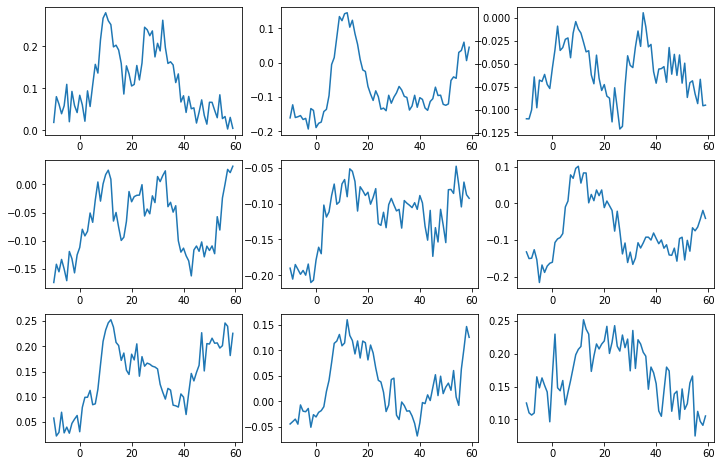

In [ ]:
num_part = len(particip_nns)

# show the peth for the neurons that pay attention to the event
for n in range(num_part):
  plt.subplot(3,3,n+1)
  plt.plot(ts, peth[particip_nns[n]][:])

sorted latencies: [1, 1, 3, 4, 5, 6, 7, 8, 8]


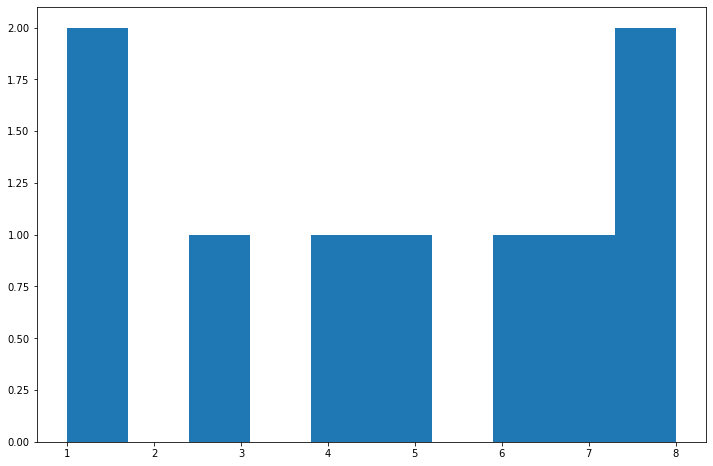

In [ ]:
# calculate the latency of the participating neurons
lat = []
for n in range(num_part):
  trace = subtract_baseline(peth[particip_nns[n]][:], baseline)
  lat.append( get_latency(trace,ev_period))

# TO DO: display participating neurons sorted by their latency
print('sorted latencies: ' + str(sorted(lat)))
sort_indx = np.argsort(lat)
#print(sort_indx)

# one way to visualize the latencies is as a historgam
plt.hist(lat);

Summary

In [ ]:
print('total neurons: '+str(num_neurons))

print('participating neurons: '+str(num_part))

print(f'{(num_part*100)/num_neurons:.2f}'+'% of the neurons pay attention to the events')

# show trial-to-trial variabily and evolution of participation analysis 


total neurons: 49
participating neurons: 9
18.37% of the neurons pay attention to the events


In this session the number of recorded neurons decreased and the percentage of participating neurons also decreased. In addition, the shapes of the event-evoked responses look less clear (e.g. sustained activity after event or bi-modal) compared to the previous sessions.

# General observations

The recorded data is organized into four recording experimental sessions. During each recording session, there are 86 events and each session has a different number of recorded neurons.  

The number of neurons that respond to the events on average (according to our criteria) is different across sessions:

- session 1: 60 neurons, 9 of them (15%) pay attention to the events  
- session 2: 9 neurons, none of them pay attention to the events.
- session 3: 109 neurons, 23 of them (21.1%) pay attention to the events.
- session 4: 49 neurons, 9 of them (18.37%) pay attention to the events.

Regarding the characterization of neural activity as a function of the temporal structure defined by their latency, each session seems to have a different temporal structure distribution. We could expand this exploratory comparison with a proper statistical comparison of the distributions (e.g. KS test, Z-test, etc.).

With additional information we could extend this characterization. For example, with more information about the sampling rate we could have a more informed selection of the time windows or inter-event statistics.



# Interesting ideas to explore

After the initial analysis presented here, there are interesting possibilities to explore:

- How reliable are the event-evoked responses across event trials? Are the participating neurons always responding to the events? or do they have variations of responses (fail-ratio) across neurons?
> Analysis: trial-to-trial variability 
- If the events are not independent from each other within a session, it would be interesting to see if the neuron activity changes across events and if so, how (linear increasing, linear decreasing, smooth vs abrupt). Of course, this would depend on the nature of the events.
If existent, are the dynamics of the event-evoked response neuron specific? i.e. are there neurons that have different dynamics of the responses? (e.g. slower vs fast adapting neurons).
> Analysis: cluster neuronal event-evoked dynamics 

- Systematic characterization of the conditions under which the neurons participate in the response to events. For example, how does the participation change per neuron if the period of the response is shortened or enlarged.
> Analysis: study of the participation parameters

- One important information that was not included in this exercise was the spatial information of the recordings (which is one of the strengths of this technique). This information could be included in the suggested future analyses to see if there are spatial relationships (e.g. neighbourhood) in the presented and suggested characterizations.
> Spatial information analysis

- Even in the absence of stimulus, sensory cortices (and the brain in general) are active. The study of spontaneous activity can be very informative for the understanding of brain function. It would be interesting to see if the event-evoked responses are brain state dependent. One way to study this would be to pay attention to the neuronal activity before the event occurs. For example, the level of coordination amongst neurons (e.g. correlation) could be used as a proxy for brain state [2]. Obviously, behavioral state information (if available) would also be very interesting to analyse in simultaneously to brain activity.
> Spontaneous activity analysis.

# References

[1] Ingiosi et al., Current Biol. 2020.

[2] Bermudez et al, Neuron. 2013


